In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/misc_projects/pyfunc/')

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
extra_str = '' # '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 200
parc_variant = 'orig' # 'orig' 'cortex_only'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight,
                                                                                       parc_variant = parc_variant)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_400_streamlineCount


## Load train/test .csv and setup node .csv

In [5]:
os.path.join(os.environ['TRTEDIR'])

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude'

In [6]:
# Load data
df = pd.read_csv(os.path.join(os.environ['TRTEDIR'], 'df_gradients.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(926, 19)


In [7]:
my_sample = 'full'

In [8]:
my_frac = 0.20
my_cut = np.round(df.shape[0]*my_frac).astype(int)
print(my_cut)
if my_sample == 'oldest':
    # Retain 'adults'
    df = df.sort_values('ageAtScan1', ascending = False).iloc[0:my_cut,:]
elif my_sample == 'youngest':
    df = df.sort_values('ageAtScan1', ascending = True).iloc[0:my_cut,:]

185


In [9]:
df['ageAtScan1_Years'].mean()

15.76965442764579

In [10]:
df['ageAtScan1_Years'].std()

3.292211495195789

In [11]:
num_subs = df.shape[0]; print(num_subs)
num_time = 120

num_connections = num_parcels * (num_parcels - 1) / 2; print(num_connections)

926
79800.0


## Load in time series, compute FC

In [12]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [13]:
# fc stored as 3d matrix, subjects of 3rd dim
roi_ts = np.zeros((num_time, num_parcels, num_subs))
fc = np.zeros((num_parcels, num_parcels, num_subs))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['RSTS_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['RSTSDIR'], file_name))
    if i == 0: print(full_path)
        
    if len(full_path) > 0:
        roi_ts_tmp = np.loadtxt(full_path[0])
        if parc_str == 'lausanne' and parc_variant == 'cortex_only':
            roi_ts_tmp = roi_ts_tmp[:,parcel_loc == 1]
    
        roi_ts[:,:,i] = roi_ts_tmp.copy()
        fc[:,:,i] = np.corrcoef(roi_ts[:,:,i], rowvar = False)
        # fisher r to z
        fc[:,:,i] = np.arctanh(fc[:,:,i])
        np.fill_diagonal(fc[:,:,i], 1)

        if np.any(np.isnan(fc[:,:,i])):
            subj_filt[i] = True

    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        roi_ts[:,:,i] = np.full((num_time, num_parcels), np.nan)
        fc[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/net/SchaeferPNC/81287_20100114x2738_SchaeferPNC_ts.1D']


/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


In [15]:
np.sum(subj_filt)

0

In [15]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    roi_ts = roi_ts[:,:,~subj_filt]
    fc = fc[:,:,~subj_filt]

In [16]:
# # Save out
# np.save(os.path.join(os.environ['MODELDIR'], 'fc'), fc)
# np.save(os.path.join(os.environ['MODELDIR'], 'roi_ts'), roi_ts)

### Generate participant gradients

In [17]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient.utils import dominant_set

In [18]:
# Generate template
pnc_conn_mat = np.nanmean(fc, axis = 2)
pnc_conn_mat[np.eye(num_parcels, dtype = bool)] = 0
# pnc_conn_mat = dominant_set(pnc_conn_mat, 0.10, as_sparse = False)

gm_template = GradientMaps(n_components = 10, approach='dm', kernel='normalized_angle', random_state = 0)
gm_template.fit(pnc_conn_mat)

if parc_scale == 200 or parc_scale == 125:
    gradients = gm_template.gradients_ * -1
elif parc_scale == 400:
    gradients = gm_template.gradients_

if my_sample == 'oldest':
    np.savetxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template_oldest.txt'),gradients)
elif my_sample == 'youngest':
    np.savetxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template_youngest.txt'),gradients)
else:
    np.savetxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template.txt'),gradients)

# Plots

In [19]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)

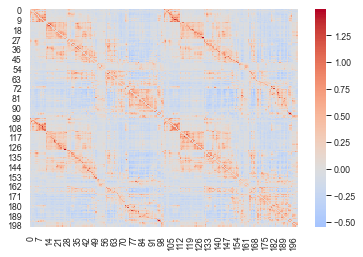

In [20]:
sns.heatmap(pnc_conn_mat, cmap = 'coolwarm', center = 0)

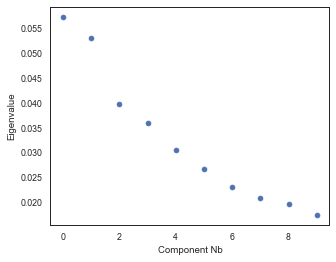

In [21]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm_template.lambdas_.size), gm_template.lambdas_)
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')

plt.show()

In [22]:
import matplotlib.image as mpimg
from brain_plot_func import brain_plot

In [23]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'
surf = 'inflated'

In [24]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


## Brain plots nispat

In [25]:
for i in range(0,2):
    for hemi in ('lh', 'rh'):
        # Plots of univariate pheno correlation
        fig_str = hemi + '_gradient_' + str(i)

        if subject_id == 'lausanne125':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
        elif subject_id == 'fsaverage':
            parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')


        brain_plot(gradients[:,i], parcel_names, parc_file, fig_str, subject_id = subject_id, surf = surf, hemi = hemi, color = 'viridis', showcolorbar = False)

colormap sequential: [-1.03e-01, -9.11e-03, 8.51e-02] (opaque)
colormap sequential: [-1.03e-01, -9.11e-03, 8.51e-02] (opaque)
colormap sequential: [-1.02e-01, -1.01e-02, 8.21e-02] (opaque)
colormap sequential: [-1.02e-01, -1.01e-02, 8.21e-02] (opaque)
colormap sequential: [-1.42e-01, -3.72e-02, 6.79e-02] (opaque)
colormap sequential: [-1.42e-01, -3.72e-02, 6.79e-02] (opaque)
colormap sequential: [-1.43e-01, -3.69e-02, 6.87e-02] (opaque)
colormap sequential: [-1.43e-01, -3.69e-02, 6.87e-02] (opaque)


In [26]:
%matplotlib inline

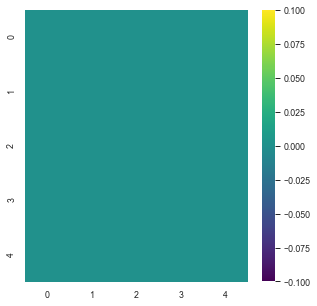

In [27]:
f, ax = plt.subplots()
f.set_figwidth(5)
f.set_figheight(5)
sns.heatmap(np.zeros((5,5)), ax = ax, cmap = 'viridis')
f.savefig('viridis.svg', dpi = 300, bbox_inches = 'tight')

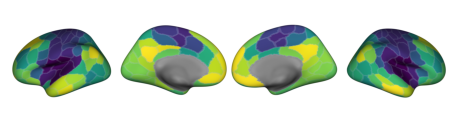

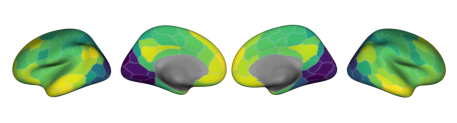

In [28]:
for i in range(0,2):

    f, axes = plt.subplots(1, 4)
    f.set_figwidth(8)
    f.set_figheight(2)
    plt.subplots_adjust(wspace=0, hspace=0)

    # column 0:
    fig_str = 'lh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,0].set_title('Thickness (left)')
        image = mpimg.imread('lat_' + fig_str); axes[0].imshow(image); axes[0].axis('off')
    except FileNotFoundError: axes[0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1].imshow(image); axes[1].axis('off')
    except FileNotFoundError: axes[1].axis('off')

    # column 1:
    fig_str = 'rh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,1].set_title('Thickness (right)')
        image = mpimg.imread('med_' + fig_str); axes[2].imshow(image); axes[2].axis('off')
    except FileNotFoundError: axes[2].axis('off')
    try:
        image = mpimg.imread('lat_' + fig_str); axes[3].imshow(image); axes[3].axis('off')
    except FileNotFoundError: axes[3].axis('off')

    plt.show()
    if my_sample == 'oldest':
        f.savefig('gradient_' + str(i) + '_oldest.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)        
    elif my_sample == 'youngest':
        f.savefig('gradient_' + str(i) + '_youngest.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)        
    else:
        f.savefig('gradient_' + str(i) + '.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

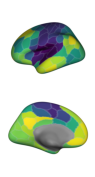

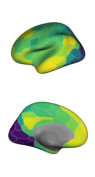

In [29]:
for i in range(0,2):

    f, axes = plt.subplots(2,1)
    f.set_figwidth(2)
    f.set_figheight(3)
    plt.subplots_adjust(wspace=0, hspace=0)

    # column 0:
    fig_str = 'lh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,0].set_title('Thickness (left)')
        image = mpimg.imread('lat_' + fig_str); axes[0].imshow(image); axes[0].axis('off')
    except FileNotFoundError: axes[0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1].imshow(image); axes[1].axis('off')
    except FileNotFoundError: axes[1].axis('off')

    plt.show()
    if my_sample == 'oldest':
        f.savefig('gradient_' + str(i) + '_oldest.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)        
    elif my_sample == 'youngest':
        f.savefig('gradient_' + str(i) + '_youngest.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)        
    else:
        f.savefig('gradient_' + str(i) + '.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)